Mounted at /content/drive
All Columns: ['Date', 'z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)', 'z2_AC8(kW)', 'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)', 'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z3_S1(degC)', 'z3_S1(RH%)', 'z3_S1(lux)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)']
Valid Power Columns: ['z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)', 'z2_AC8(kW)', 'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)', 'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)']
Valid Environmental Columns: ['z1_S1(degC)', 'z1_S1(

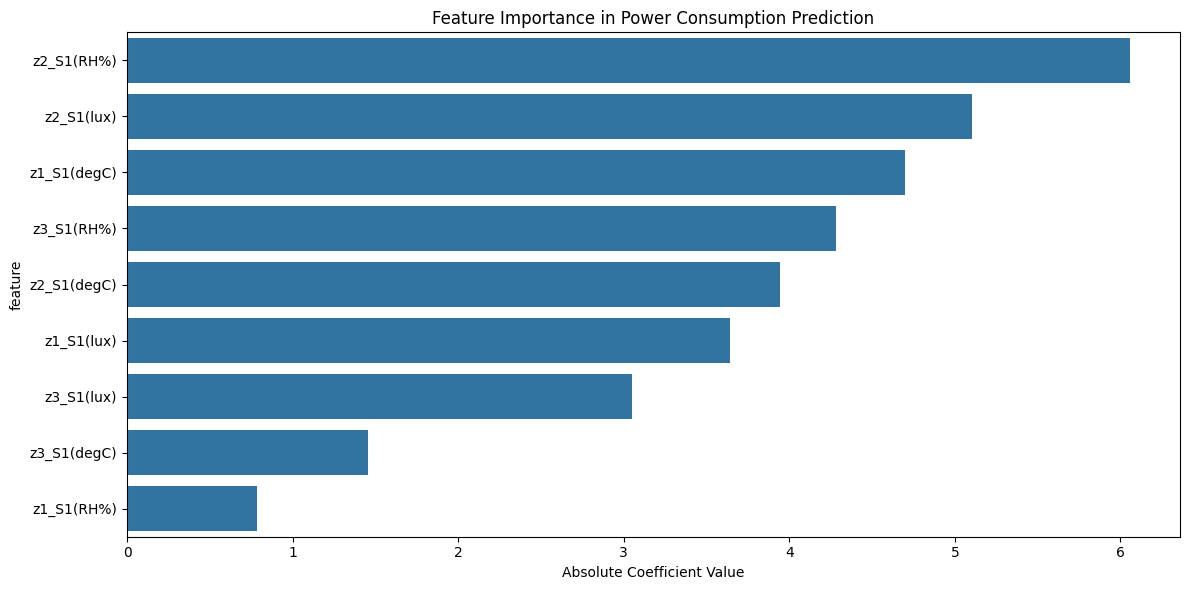

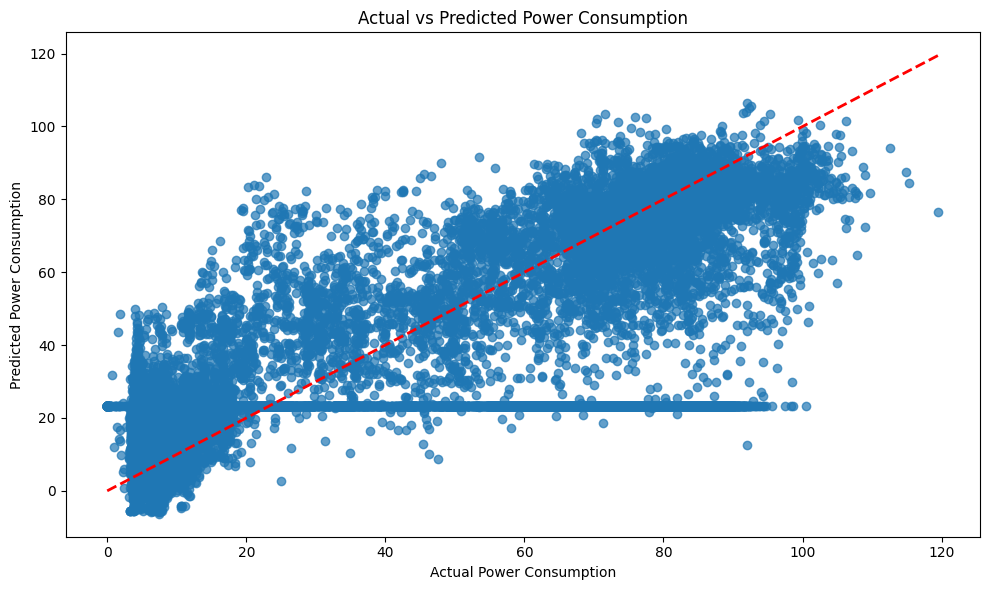

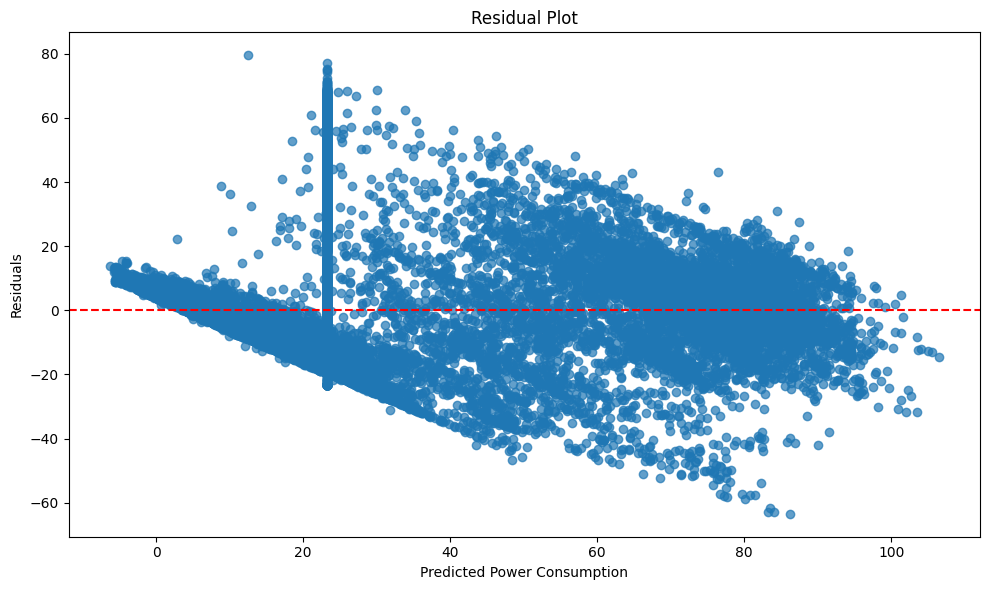


Data Quality Summary:
Total Rows: 264960
Total Power Consumption Columns: 24
Total Environmental Columns: 9

Detailed Feature Importance:
       feature  importance
4   z2_S1(RH%)    6.056845
5   z2_S1(lux)    5.106385
0  z1_S1(degC)    4.696603
7   z3_S1(RH%)    4.281450
3  z2_S1(degC)    3.945949
2   z1_S1(lux)    3.644628
8   z3_S1(lux)    3.049272
6  z3_S1(degC)    1.452398
1   z1_S1(RH%)    0.782579


In [34]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Path to your dataset
file_path = '/content/drive/MyDrive/FDP/Assignments/Task 2/2018Floor2.csv'

# Load the dataset
df = pd.read_csv(file_path)

def preprocess_data(df):
    # Print full column names for debugging
    print("All Columns:", list(df.columns))

    # Identify power consumption columns
    power_columns = [col for col in df.columns if '(kW)' in col]

    # Identify environmental columns
    env_columns = [col for col in df.columns
                   if any(indicator in col for indicator in ['(degC)', '(RH%)', '(lux)'])]

    # Remove columns with all or almost all missing values
    def is_valid_column(col):
        missing_ratio = df[col].isnull().sum() / len(df)
        return missing_ratio < 0.9  # Keep columns with less than 90% missing values

    valid_power_columns = [col for col in power_columns if is_valid_column(col)]
    valid_env_columns = [col for col in env_columns if is_valid_column(col)]

    print("Valid Power Columns:", valid_power_columns)
    print("Valid Environmental Columns:", valid_env_columns)

    # Prepare features
    X = df[valid_env_columns].copy()

    # Prepare target (total power consumption)
    y = df[valid_power_columns].sum(axis=1)

    return X, y, valid_power_columns, valid_env_columns

try:
    # Prepare data
    X, y, valid_power_columns, valid_env_columns = preprocess_data(df)

    # Handle any remaining missing values in features
    X = X.fillna(X.median())

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a pipeline with scaling and regression
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # Model Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print Results
    print("\nModel Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")

    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(pipeline.named_steps['regressor'].coef_)
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Visualization of Feature Importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in Power Consumption Prediction')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()

    # Actual vs Predicted Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Power Consumption')
    plt.xlabel('Actual Power Consumption')
    plt.ylabel('Predicted Power Consumption')
    plt.tight_layout()
    plt.show()

    # Residual Analysis
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Power Consumption')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Additional Data Quality Checks
    print("\nData Quality Summary:")
    print("Total Rows:", len(df))
    print("Total Power Consumption Columns:", len(valid_power_columns))
    print("Total Environmental Columns:", len(valid_env_columns))

    print("\nDetailed Feature Importance:")
    print(feature_importance)

except Exception as e:
    print("An error occurred:")
    print(e)
    import traceback
    traceback.print_exc()